<a href="https://colab.research.google.com/github/connor735/344_test/blob/main/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1: nearest neighbors for data imputation

Real-world datasets often have missing values: this can be due to hardware faults (e.g., a sensor failing), data corruption, ambiguity, or even by design (think about surveys with optional questions). In Python, the special value `NaN` (not-a-number) can be used to indicate a missing value.

Dealing with missing data is not straightforward. One option is to *remove* any sample with missing features $x_{i}$ (or label $y$). However, there are several datasets for which *almost all* samples have one or more missing feature values, and we would be throwing away all the information contained in the non-missing values.

In this problem, we explore the use of the $k$-nearest neighbors algorithm for *data imputation*.

## Question 1

Suppose that you are solving a regression problem where **the only potential missing values are response labels $y^{(i)}$**. Describe a method, based on the $k$-nearest neighbors algorithm, to fill-in missing values based on the available response labels. When do you expect your method to work well, and when do you expect it to produce poor results? Justify your answers and design choices.

## Question 2
Implement your method from Question 1 by completing the provided code snippet in `p1.py` (in the `KnnLabelImputer` class) and **submit it to Gradescope**. You can use the `regression_dataset_with_missing_responses` function, provided in the next code cell, to generate example inputs to help with development.

## Question 3
Now, suppose that we are solving a *classification* problem, and we know that *no labels $y^{(i)}$ are missing*. However, there are now missing *feature* values. Like in **Question 1**, describe a method based on the $k$-nearest neighbors algorithm for performing data imputation on the features of the dataset. You can assume that there are enough samples for each distinct class label. When do you expect your method to work well, and when not to? Justify your answers and design choices.

**Tip**: The nearest neighbors implementation in `scikit-learn` allows you to define your own distance function via the `metric` parameter. You can use this to define a distance function that takes into account missing values and class membership. Think about how you can modify the distance function to favor samples with the same class label.

## Question 4
Implement your method from Question 3 by completing the provided code template in `p1.py` (in the `KnnFeatureImputer` class) and **submit it to Gradescope**. You can use the `classification_dataset_with_missing_features` function from the following cell to generate example inputs to help with development.

Q1 Answer:

A method based on the k-nearest neighbors algorithm to fill in missing values based on the availavble response labels would be to average the k nearest neighbors values to come up with one. For example if one x has no y value, then you average the y values of nearby x that do not have missing y's. Do this for a small set of neighbors in a close range and you can come up with a fairly accurate y for the missing value. I would expect this to work well when y varies smoothly together. For example in a straight line it would be easy to average nearby y values to get a value compared to y values that are all over the place. Also if the data is dense then you don't have to average over that wide of a range of (x,y) value pairs. Compared to when the data is spread out it becomes less accurate. If there are too many y values missing I would expect this to do poorly as well. Like if all of the neighbors also had their y values missing.


Q3 Answer:

A method based on the k-nearest neighbors algorith for performing data imputation on the features of the data set would start by finding the values of the features in the same class of labels. Given many feature per label we can use the distance function to figure out how far away the rest of the features in the class are. Given this information we can select the k nearest features of other labels and then average their values of our missing feature. We take this average and it becomes the missing feature value.



In [55]:
from sklearn.base import BaseEstimator, TransformerMixin

class KnnLabelImputer(BaseEstimator, TransformerMixin):
    def __init__(self, k: int = 3):
        self.k = k

    def fit(self, X, y):
        assert y is not None
        X = np.asarray(X)
        y = np.asarray(y, dtype=float)

        self.scaler = StandardScaler().fit(X)
        X_scaled = self.scaler.transform(X)

        known_mask = ~np.isnan(y)

        self.X_known = X_scaled[known_mask]
        self.y_known = y[known_mask]

        return self

    def fit_transform(self, X, y=None, **fit_params):
        return super().fit_transform(X, y, **fit_params)

    def transform(self, X, y):


        """Replace missing responses with the mean of the nearest neighbors' responses.

        Args:
            X: The features.
            y: The original responses.

        Returns:
            The imputed responses.
        """
        assert y is not None
        X = np.asarray(X)
        y = np.asarray(y, dtype=float).copy()

        X_scaled = self.scaler.transform(X)

        missing_idx = np.where(np.isnan(y))[0]

        eps = 1e-12
        for i in missing_idx:

            dists = np.sqrt(np.sum((self.X_known - X_scaled[i]) ** 2, axis=1))


            k_near = np.argpartition(dists, self.k - 1)[:self.k]


            nn_y = self.y_known[k_near]
            nn_d = dists[k_near]


            weights = 1 / (nn_d + eps)
            y[i] = np.sum(weights * nn_y) / np.sum(weights)


        return y

class KnnFeatureImputer(BaseEstimator, TransformerMixin):
    def __init__(self, k: int = 3):
        self.k = k

    def fit(self, X, y):
        X = np.asarray(X, dtype=float); y = np.asarray(y)
        col_mean = np.nanmean(X, axis=0)
        X_fill = np.where(np.isnan(X), col_mean, X)
        self.scaler_ = StandardScaler().fit(X_fill)
        self.Xs_ = self.scaler_.transform(X_fill)
        self.y_ = y
        self.cls_idx_ = {c: np.where(y == c)[0] for c in np.unique(y)}
        self.cls_mean_ = {c: np.nanmean(self.Xs_[idx], axis=0) for c, idx in self.cls_idx_.items()}
        self.glob_mean_ = np.nanmean(self.Xs_, axis=0)
        return self


    def fit_transform(self, X, y, **fit_params):
        return super().fit_transform(X, y, **fit_params)

    def transform(self, X, y):
        X = np.asarray(X, dtype=float); y = np.asarray(y)
        col_mean = np.nanmean(X, axis=0)
        X_fill = np.where(np.isnan(X), col_mean, X)
        Xs = self.scaler_.transform(X_fill)
        out = Xs.copy(); eps = 1e-12

        for i in range(X.shape[0]):
            miss = np.isnan(X[i]);
            if not np.any(miss): continue
            c = y[i]; pool_ids = self.cls_idx_.get(c)
            pool = self.Xs_[pool_ids] if pool_ids is not None else self.Xs_
            q = out[i]; qmask = ~np.isnan(q)

            # NaN-aware distances (overlap only)
            dists = np.empty(pool.shape[0]);
            for r in range(pool.shape[0]):
                pmask = ~np.isnan(pool[r]); m = qmask & pmask
                dists[r] = np.inf if not np.any(m) else np.sqrt(np.mean((q[m]-pool[r,m])**2))

            finite = np.isfinite(dists)
            if finite.sum() == 0:
                cm = self.cls_mean_.get(c, self.glob_mean_)
                fill = cm[miss]; fill[np.isnan(fill)] = self.glob_mean_[miss]
                out[i, miss] = fill; continue

            k_eff = min(self.k, finite.sum())
            nn_idx = np.where(finite)[0][np.argpartition(dists[finite], k_eff-1)[:k_eff]]
            nn = pool[nn_idx]; nd = dists[nn_idx]

            for f in np.where(miss)[0]:
                vals = nn[:, f]; ok = ~np.isnan(vals)
                if not np.any(ok):
                    v = self.cls_mean_.get(c, self.glob_mean_)[f]
                    out[i, f] = v if not np.isnan(v) else self.glob_mean_[f]
                else:
                    d = nd[ok]; x = vals[ok]
                    if np.any(d < 1e-10): out[i, f] = np.nanmean(x[d < 1e-10])
                    else:
                        w = 1/(d+eps); out[i, f] = np.sum(w*x)/np.sum(w)

        return self.scaler_.inverse_transform(out)

In [56]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.datasets import make_classification


def regression_dataset_with_missing_responses(
    n_samples: int, n_features: int, p_missing: float = 0.1
):
    """
    Generate a regression dataset with missing responses.

    Args:
        n_samples: Number of samples.
        n_features: Number of features.
        p_missing: Probability of missing a response.

    Returns:
        A Pandas DataFrame with features and a response column.
    """
    X, y = make_regression(
        n_samples=n_samples,
        n_features=n_features,
    )
    # Replace response values by NaN with probability p_missing.
    y = np.where(np.random.rand(*y.shape) < p_missing, np.nan, y)
    X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(n_features)])
    return pd.concat([X, pd.Series(y, name="response")], axis=1)


def classification_dataset_with_missing_features(
    n_samples: int, n_features: int, p_missing: float = 0.1, n_classes: int = 3
):
    """
    Generate a classification dataset with missing features.

    Args:
        n_samples: Number of samples.
        n_features: Number of features.
        p_missing: Probability of missing a feature.
        n_classes: Number of classes.

    Returns:
        A Pandas DataFrame with features and a label column.
    """
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_classes=n_classes,
        n_clusters_per_class=1,
    )
    # Replace feature values in X by NaN with probability p_missing.
    X = np.where(np.random.rand(*X.shape) < p_missing, np.nan, X)
    X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(n_features)])
    return pd.concat([X, pd.Series(y, name="label")], axis=1)

In [65]:
# Example: regression dataset with 500 samples 20 features, and approximately 10% of responses missing
df = regression_dataset_with_missing_responses(500, 10, p_missing=0.1)
X = df.drop(columns=["response"]).values
y = df["response"].values

print("NaNs in response before:", int(np.isnan(y).sum()))

# --- 2) fit & 3) transform ---
imp = KnnLabelImputer(k=5).fit(X, y)   # learn scaler and keep only known y
y_imputed = imp.transform(X, y)        # fill NaNs via kNN on scaled X

print("NaNs in response after :", int(np.isnan(y_imputed).sum()))

# --- 4) put back into the DataFrame (if you want the imputed dataset) ---
df_imputed = df.copy()
df_imputed["response"] = y_imputed

# peek at a few rows that were missing
missing_idx = np.where(np.isnan(y))[0][:5]
print(df_imputed.iloc[missing_idx][["response"]].head())
dataset.head()

NaNs in response before: 49
NaNs in response after : 0
      response
9   267.564439
21   47.743441
24  -53.199971
27  -73.975218
29 -248.005162


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,response
0,0.575100,0.112258,0.406598,-0.599152,0.600409,-1.372021,1.073854,0.881829,0.475626,-1.141109,39.369426
1,0.861890,0.203234,2.019801,0.162789,0.227402,1.044531,0.499028,0.171832,-0.198228,0.792113,368.173360
2,-1.392773,-0.432290,2.662878,-0.581545,0.965309,0.433500,-0.507915,-1.456435,0.801774,0.003238,100.320882
3,-0.127056,1.771402,-0.078590,-1.320467,1.106150,-0.276846,0.471169,-0.249523,1.311184,-0.350101,183.443841
4,0.432418,-0.803534,-0.049538,0.003505,1.314278,-0.093313,2.402127,-0.036544,-0.317331,-0.827183,195.165543


In [68]:
# Example: classification dataset with 500 samples 10 features, and 10% of responses missing
dataset = classification_dataset_with_missing_features(500, 10, p_missing=0.1)
X = dataset.drop(columns=["label"]).values
y = dataset["label"].values

print("NaNs in X before:", int(np.isnan(X).sum()))

imp = KnnFeatureImputer(k=5).fit(X, y)
X_imp = imp.transform(X, y)

# Optional final safety fill (should be zero already)
if np.isnan(X_imp).any():
    col_mean = np.nanmean(X_imp, axis=0)
    rows, cols = np.where(np.isnan(X_imp))
    X_imp[rows, cols] = col_mean[cols]

print("NaNs in X after :", int(np.isnan(X_imp).sum()))
print(pd.DataFrame(X_imp, columns=[f"feature_{i}" for i in range(X_imp.shape[1])]).head())
dataset.head()

NaNs in X before: 495
NaNs in X after : 0
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.396397   1.047622   1.633612   0.236979   1.528709   0.793417   
1   0.089114   0.288573   0.301527   0.137920  -1.063455  -0.948722   
2   0.359680   1.445534   0.151245  -0.453948  -0.204010   0.447921   
3   0.788802   0.529338  -0.567700  -0.946037  -0.475747  -0.445934   
4  -0.061156   0.535375   0.031000  -0.176577   0.995055   0.717962   

   feature_6  feature_7  feature_8  feature_9  
0   0.991673  -1.065446   0.022540  -1.832920  
1   0.268547  -0.294595   0.022540  -1.248810  
2   1.328995  -1.427684   0.107322  -2.434408  
3   0.796131  -0.856687   0.331935  -1.636409  
4  -0.239019   0.260162  -0.590898   0.858611  


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,label
0,0.396397,1.047622,1.633612,0.236979,1.528709,0.793417,0.991673,-1.065446,NaN,-1.832920,2
1,0.089114,NaN,0.301527,0.137920,-1.063455,-0.948722,0.268547,-0.294595,NaN,-1.248810,0
2,0.359680,1.445534,0.151245,-0.453948,-0.204010,0.447921,1.328995,-1.427684,0.107322,-2.434408,2
3,0.788802,0.529338,-0.567700,-0.946037,-0.475747,-0.445934,0.796131,-0.856687,0.331935,-1.636409,2
4,-0.061156,0.535375,NaN,-0.176577,0.995055,0.717962,-0.239019,0.260162,-0.590898,0.858611,1


# Problem 2: cross-validation for imbalanced datasets

In class, we discussed the use of cross-validation to estimate model performance on unseen data. However, extra care must be taken in cases where our data is *unbalanced*. This is best explained via a cautionary (fictional) tale.


> An aerospace engineer is tasked with creating and fine-tuning a classifier that processes post-flight images of aircraft wings and screens them for the presence of fractures. To train the classifier, they are given access to a dataset of labeled images ($0$ indicates no fracture, $1$ indicates fracture). Following the advice of an LLM, the engineer writes a `scikit-learn` pipeline that:
>
> - pre-processes the data, splits them into $K = 20$ folds using the built-in `KFold` class
> - trains several logistic regression models, one for each fold, and
> - selects the best model based on the estimated (via cross-validation) F1 score.
>
> However, 5 years after they deploy their model, maintenance engineers suggest that it failed to detect several fractures, leading to higher degradation of the aircraft and many more dollars lost. **What went wrong?**


A likely answer is that the dataset is very imbalanced. Specifically, wings are usually structurally intact after flight; unless special care was taken while curating the dataset, most labels will be negative and many folds will not contain any samples from the positive class. Therefore, it is possible that a classifier that always outputs "negative" leads to good F1 score as estimated via cross-validation.

To fix this, we augment K-fold cross validation with the idea of **stratified** sampling. Stratified sampling splits the data in a way that approximately preserves the fraction of class labels within each fold. In `scikit-learn`, this is easy to implement via the `StratifiedKFold` class.

## Question 1

Use the provided function `make_imbalanced_classification_dataset()` below to generate datasets with 500 samples and 50 features. Train a logistic regression classifier using (a) `KFold` and (b) `StratifiedKFold` cross-validation for different values of $K$, and plot the resulting F1 score as a function of the number of folds $K$. Are the results expected or surprising, and why?

> **Note**: you can implement the cross-validation yourself or use the built-in `cross_val_score` function from `scikit-learn` or use the `LogisticRegressionCV` model with the appropriate cross-validation generator.

## Question 2
Another potential approach is to adjust the classification threshold (instead of the default $\frac{1}{2}$). For example, we can make the classifier much more conservative by outputting a positive label after a threshold of $\frac{1}{10}$. Do you think this is a good idea? Why or why not?

Q1 Answer:

The results are a little surprising. The stratified k-fold is only a little bit better than the standard k-fold. As K increases the F1 score of both models drops. This is because as there is more folds there is a higher chance a fold has no fracture case to train on in the K-fold case. When the number of folds go up there is less data per fold and thus less to train on. This makes it harder for the model to be accurate when in use and decreases the F1 score.

The stratified K-fold helps this effect by ensuring that each fold atleast has some positive and some negative samples. This ensures a higher F1 score in the begining but as it increases higher it goes much lower just like the regular K-fold.

Overall the Stratified K-Fold held for a few more folds at a higher value than the standard K-fold did. While not having a massive difference this is still very beneficial.

Q2 Answer:

For this specific application it could be helpful. In trying to see if airplaine wings are fractured you probably want a high false positive rate rather than a false negative (there is a fracture and not detected). However overall this is not a good practice. It may still be very inacurate if there are too many folds and the F1 is very low. Meaning it still may not detect anything. This solution is like putting a band-aid on a bulet wound, there is a deeper issue that should be adressed via stratifiedKfold instead.

In [19]:
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd


def make_imbalanced_classification_dataset(
    n_samples: int, n_features: int, class_imbalance: float
) -> pd.DataFrame:
    """
    Make an imbalanced classification dataset.

    Args:
        n_samples: The number of samples.
        n_features: The number of features.
        class_imbalance: The proportion of samples assigned to each class.
    """
    if class_imbalance <= 0 or class_imbalance >= 1:
        raise ValueError("class_imbalance must be between 0 and 1")
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_classes=2,
        weights=[class_imbalance, 1 - class_imbalance],
    )
    X = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(n_features)])
    return pd.concat([X, pd.Series(y, name="label")], axis=1)

In [ ]:
dataset = make_imbalanced_classification_dataset(100, 10, 0.1)
dataset.head(10)

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,label
0,-2.296305,0.558066,1.985806,2.060711,-1.151544,0.667886,0.279719,-1.980083,-0.499367,0.021662,1
1,-1.616681,0.156136,-0.276573,1.528218,-1.374735,-0.325099,0.103674,-1.046514,0.977074,1.562300,1
2,0.751483,-0.359631,0.264306,1.715599,-1.306755,0.007692,1.380044,-1.366477,0.429842,0.241453,1
3,0.047478,-1.110326,0.010043,0.346627,0.852322,1.760256,-0.644266,-1.180543,-0.341410,-0.396855,1
4,-1.181400,-0.549346,1.311023,0.749616,-1.461725,-1.399937,0.813728,0.124609,0.630830,0.235712,1
5,0.584226,0.750845,1.889760,0.630578,0.464150,1.490733,-0.573903,-1.267447,-0.389361,0.747053,1
6,0.544818,-0.544799,-0.170519,0.646807,-1.461107,-1.522793,-0.580223,0.269441,0.014286,0.805503,1
7,-0.310833,-0.098265,1.089986,0.456879,-1.530201,-1.860406,-0.463981,0.593907,-0.550436,1.418798,1
8,-0.093019,-0.830193,0.454977,1.498925,-0.168621,1.539746,0.835698,-1.982290,0.240333,-0.732097,1
9,-0.621580,0.210354,1.161733,1.000285,-1.427692,-1.044399,0.682135,-0.257315,0.793770,1.031048,1


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=15.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=20.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=45.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 10 members, which is less than n_splits=50.
  warnings.warn(


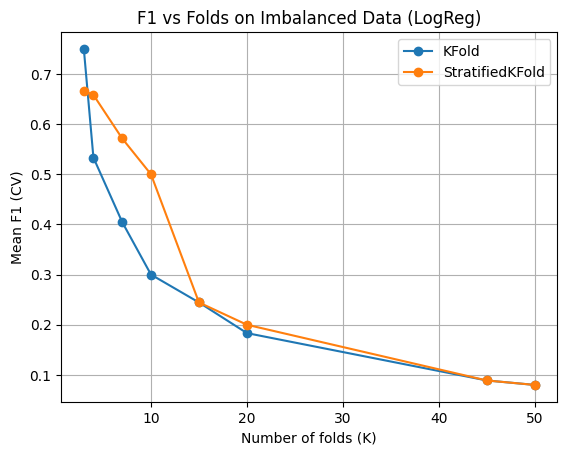

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score


def make_imbalanced_classification_dataset(n_samples=500, n_features=50, pos_ratio=0.02, random_state=0):
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=10,
        n_redundant=10,
        n_clusters_per_class=1,
        weights=[1 - pos_ratio, pos_ratio],
        flip_y=0.0,
        random_state=random_state,
    )
    return X, y

X, y = make_imbalanced_classification_dataset()


Ks = [3, 4, 7, 10, 15, 20, 45, 50]
f1_kfold = []
f1_stratkfold = []


base_model = LogisticRegression(max_iter=2000, solver="lbfgs")

for K in Ks:

    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    try:
        scores_k = cross_val_score(base_model, X, y, scoring="f1", cv=kf, n_jobs=-1)
        f1_kfold.append(np.mean(scores_k))
    except Exception:

        f1_kfold.append(np.nan)


    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=0)
    scores_s = cross_val_score(base_model, X, y, scoring="f1", cv=skf, n_jobs=-1)
    f1_stratkfold.append(np.mean(scores_s))


plt.figure()
plt.plot(Ks, f1_kfold, marker="o", label="KFold")
plt.plot(Ks, f1_stratkfold, marker="o", label="StratifiedKFold")
plt.xlabel("Number of folds (K)")
plt.ylabel("Mean F1 (CV)")
plt.title("F1 vs Folds on Imbalanced Data (LogReg)")
plt.legend()
plt.grid(True)
plt.show()



# Problem 3: dimension reduction via random projections

In class, we discussed how PCA discovers a few important degrees of freedom of high-dimensional datasets.

The main idea was the following:

> *If data are mostly contained on a low-dimensional subspace, let's discover that subspace and project the data onto it.*

The number of principal components, $k$ reflects our "guess" for the dimension of that subspace.

Another dimension reduction method featuring prominently in theoretical computer science is that of so-called "random projections". Setting the stage, suppose we have $n$ data points living in $d$-dimensional space ($\mathbb{R}^d$ for simplicity). The random projections method proceeds as follows:

- Generate $k$ vectors, $g^{(1)}, \dots, g^{(k)}$, randomly (often according to a Gaussian distribution).
- Arrange these vectors as the columns of a matrix:

$$
\Pi := \begin{bmatrix}
	g^{(1)} & \cdots & g^{(k)}
\end{bmatrix} \in \mathbb{R}^{d \times k}.
$$

- For each of the $n$ points in your dataset, say $x^{(1)}, \dots, x^{(n)}$:
	- Compute the product $\widetilde{x}^{(i)} = \Pi^{\top} x^{(i)}$.
- This results in a matrix $\widetilde{X} \in \mathbb{R}^{n \times k}$ containing the "reduced" dataset.
- Downstream tasks (e.g., regression or classification) can be performed on the reduced dataset instead.
    - Any new data point $x$ can be projected to $\widetilde{x} := \Pi^{\top} x$.


The random projections method works because the matrix $\Pi$ produces "low distortion": for all pairs $i \neq j$,

$$
(1 - \varepsilon) \|x^{(i)} - x^{(j)}\| \leq \| \widetilde{x}^{(i)} - \widetilde{x}^{(j)}\| \leq (1 + \varepsilon) \|x^{(i)} - x^{(j)}\|,
$$

whenever the number of the random vectors $k$ satisfies the following inequality:

$$
k \geq \frac{10 \log(n)}{\varepsilon^2}.
$$

> Note that the ambient dimension, $d$, **does not appear** in the bound at all! This result is known in the literature as the *Johnson-Lindenstrauss lemma*.

In this exercise, you will explore the use of random projections with 2 different variants: one where the random vectors are dense, and one where the random vectors are *sparse* (i.e., mostly zeros). Then, you will compare the quality of the resulting embeddings with that provided by principal component analysis.

## Question 1

Download the code template `p3.py`. You will find two functions with the following code signatures:

```python
def apply_sparse_random_projections(dataset: ArrayLike, num_projections: int) -> ArrayLike:
	...

def apply_dense_random_projections(dataset: ArrayLike, num_projections: int) -> ArrayLike:
	...
```

These functions accept a `dataset` (e.g., a Numpy table) where each row is a sample and the number of projections $k$, `num_projections`. They should return the reduced dataset after applying the random projections method. Implement both methods and submit your code to Gradescope.

> **Tip**: Use the `SparseRandomProjection` and `GaussianRandomProjection` classes from `scikit-learn`. You will have to instantiate them with the appropriate arguments.

## Question 2

Use the provided snippet below to create a high-dimensional dataset. Using your implementation from Question 1, compute the following quantities for $k = 2^{j}$ ($j = 2, \dots, 10$):

- **Maximum and minimum distortion**: the min and max ratio of distances between projected and original data points.

  $$
  \gamma_{\mathsf{upper}} := \max_{i \neq j} d_{i, j} \;\; \text{and} \;\; \gamma_{\mathsf{lower}} := \min_{i \neq j} d_{i, j},
  $$
  
  where we define the ratios $d_{i,j}$ as follows:
  
  $$
  \frac{\|\widetilde{x}^{(i)} - \widetilde{x}^{(j)}\|}{\|x^{(i)} - x^{(j)}\|}.
  $$

- The ratio $\sqrt{\frac{\lceil \log n \rceil}{k}}$.

Make a plot of these quantities as a function of $k$ (once for sparse and once for dense random projections). In your narrative writeup, discuss the following questions:

- Is the behavior of these quantities surprising as you increase $k$? Why or why not?
- Is the behavior of these quantities surprising as you move from sparse to dense random projections? Why or why not?
- Would you recommend this method for a huge dataset (very large $n$) of relatively small dimension ($d$)? Why or why not?

## Question 3

For the same dataset, compare the distortion factors from Question 1 with those attained by PCA (using $k$ as the number of  principal components); do this **for all** $k$ you tried in Question 1 and make a shared plot depicting the distortion factors for both methods as a function of $k$.

- Are the distortion factors from PCA higher or lower?
- Which distortion factor did you expect to be higher before you completed the question, and why?

Q2 Answer:

A. The behavior of these quantities is not surprising as k increases. This is not surprising due to the equations provided. As k increases the ratio decreases, as k is in the denominator. As the equations show the method works because the distances from 1 are always (1+ratio, or 1-ratio). So it makes sense that our graph shows movement towards one on both sides as k increases.

B. It is not surprising that the sparse projections are further from 1 than the dense ones. This is because the sparse line uses fewer inputs per point. Thus it gives more of a rough estimate of the line. The dense line uses every iunput so it is very set. Also the reason the lower sparse line is not as varied is because there are fewer inputs points to choose from, making it less likely it gets a wild output. It also makes sense that both get closer to 1 as k increases.

C. If you have a ton of rows but only a few columnns, large and small d, I would not reccomend this method. If d is already small there is no need to reduce it further. Instead it may actually take a lot of time to reduce d when n is so large (and for litle gain). Other methods are more efficent.


Q3 Answer:


In [21]:
from numpy.typing import ArrayLike

from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection

def apply_sparse_random_projections(dataset: ArrayLike, num_projections: int) -> ArrayLike:
    rp = SparseRandomProjection(n_components=num_projections, dense_output=False, random_state=0)
    return rp.fit_transform(dataset)
def apply_dense_random_projections(dataset: ArrayLike, num_projections: int) -> ArrayLike:
    rp = GaussianRandomProjection(n_components=num_projections, random_state=0)
    return rp.fit_transform(dataset)


In [20]:
# Code to create a high-dimensional dataset
import pandas as pd
import numpy as np
from sklearn.datasets import make_friedman1


def create_high_dim_dataset(n_samples: int, n_features: int) -> pd.DataFrame:
    X, y = make_friedman1(
        n_samples=n_samples,
        n_features=n_features - 1,
        noise=0.1,
        random_state=42,
    )
    return pd.DataFrame(np.hstack([X, y.reshape(-1, 1)]))

/usr/local/lib/python3.12/dist-packages/sklearn/random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (500 < 512).The dimensionality of the problem will not be reduced.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (500 < 512).The dimensionality of the problem will not be reduced.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (500 < 1024).The dimensionality of the problem will not be reduced.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_feature

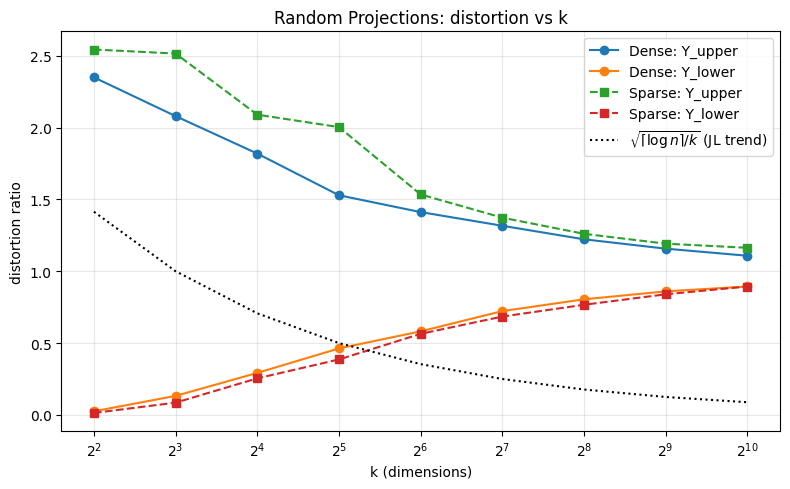

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import pairwise_distances


n, d = 2000, 500
X, _ = make_classification(n_samples=n, n_features=d, n_informative=50,
                           n_redundant=50, n_repeated=0, n_classes=5,
                           random_state=0, shuffle=True)

D = pairwise_distances(X, metric="euclidean")
iu = np.triu_indices(n, k=1)
D_vec = D[iu]

def distortion_stats(X_tilde):
    Dt = pairwise_distances(X_tilde, metric="euclidean")[iu]
    ratio = Dt / (D_vec + 1e-12)
    return np.min(ratio), np.max(ratio)

ks = [2**j for j in range(2, 11)]
min_dense, max_dense, jl_dense = [], [], []
min_sparse, max_sparse, jl_sparse = [], [], []

logn = np.log(len(X))
for k in ks:
    Xd = apply_dense_random_projections(X, k)
    xs_min, xs_max = distortion_stats(Xd)
    min_dense.append(xs_min); max_dense.append(xs_max)
    jl_dense.append(np.sqrt(np.ceil(logn) / k))

    Xs = apply_sparse_random_projections(X, k)
    xs_min, xs_max = distortion_stats(Xs)
    min_sparse.append(xs_min); max_sparse.append(xs_max)
    jl_sparse.append(np.sqrt(np.ceil(logn) / k))

# ----- plots -----
plt.figure(figsize=(8,5))
plt.plot(ks, max_dense, 'o-', label='Dense: Y_upper')
plt.plot(ks, min_dense, 'o-', label='Dense: Y_lower')
plt.plot(ks, max_sparse, 's--', label='Sparse: Y_upper')
plt.plot(ks, min_sparse, 's--', label='Sparse: Y_lower')
plt.plot(ks, jl_dense, 'k:', label=r'$\sqrt{\lceil \log n \rceil / k}$ (JL trend)')
plt.xscale('log', base=2)
plt.xlabel('k (dimensions)')
plt.ylabel('distortion ratio')
plt.title('Random Projections: distortion vs k')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
Do code for q3

# Problem 4: Kaggle competition

In this problem, you will work on the [Diabetes Health Indicators dataset](https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset) from Kaggle. The dataset comprises responses to a CDC survey. The code in the cell below splits the dataset into features and labels, resulting in a binary classification task. For this problem, your only deliverable should be a Jupyter notebook that implements all the necessary code and addresses the following questions:

## Question 1

The dataset contains numeric, nominal and ordinal features. Which features fall into which category, and how should we preprocess each category?

## Question 2

Train a classifier for the binary classification task, and report the average accuracy and Area-Under-Curve (AUC) using 5-fold cross-validation. Does this problem warrant using additional metrics, such as the F1 score, in addition to accuracy? Why or why not?

**Note**: You are allowed to choose any model suitable for binary classification you want, in addition to those you have already seen in class. You are welcome to peruse the scikit-learn documentation for additional models, if you want to try them out.

## Question 3

If you wanted to further improve the performance of your classifier for this problem, what additional methods / model improvements would you consider and why?

Q1 Answer:
Numeric:
Age, physical activity minutes per week, diet score, sleep hours per day, screen time hours per day, bmi, waist to hip ratio, systolic bp, diastolic bp, heart rate, alchohal consumption per week

Ordinal:
education level, income level,

Nominal:
Gender, ethnicity, employment status, smoking status, family history diabetes, hypertension history, cardiovascular history

First to preproces we listed each column as their respected data type and declared anything extra that data type needed.

To preprocess the numeric category we should:
Run the imputer for any missing values and scales them via standard scaler.

To preprocess the ordinal category we should:
Run the imputer to imput any missing values and encode the categories into numbers via the ordinal encoder.

To preprocess the nominal category we should:
Run the iumputer for missing values and run the one hot encoder to put it into number format.

Finally we put it all together into one numerical matrix.

Q2 Answer:

This problem does warrant using additional metrics such as the F1 score. The f1 score is 2*((precision*recall)/(precision+recall)). This means it averages out the two and shows if one is way higher than the other. If both are high than the f1 score is high. In this case the f1 score is high so it shows us the model is high in precision and recall.

Q3 Answer:

I would consider computing the actual precision and recall values. While they can be seen in the F1 score it would be nice to see them seperately to see which is higher. Also to improve the method we could use a stratified k-fold instead of a normal k-fold. As explored previously it would increase the F1 score as it ensures each fold has atleast a few of each cases.

In [76]:
import kagglehub
import os
import pandas as pd

# Download latest version
path = os.path.join(
    kagglehub.dataset_download("mohankrishnathalla/diabetes-health-indicators-dataset"),
    "diabetes_dataset.csv",
)
df = pd.read_csv(path)

# Define the feature and labels
# We want to solve the binary classification task, drop the other two labels
features = df.drop(columns=["diabetes_risk_score", "diabetes_stage", "diagnosed_diabetes"])
labels = df["diagnosed_diabetes"]

Using Colab cache for faster access to the 'diabetes-health-indicators-dataset' dataset.


In [77]:
features.head()

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,78,68,239,41,160,145,136,236,6.36,8.18
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,76,67,116,55,50,30,93,150,2.00,5.63
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,73,74,213,66,99,36,118,195,5.07,7.51
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,93,68,171,50,79,140,139,253,5.28,9.03
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,67,67,210,52,125,160,137,184,12.74,7.20


In [78]:
labels.head()

,diagnosed_diabetes
0,1
1,0
2,1
3,1
4,1


In [79]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder


nominal = ["gender", "ethnicity", "employment_status", "smoking_status"]


ordinal = ["education_level", "income_level"]

ord_maps = [
    ["No formal","Highschool", "Graduate","Postgraduate"],  # education_level
    ["Low", "Lower-Middle", "Middle", "Upper-Middle", "High"], # income_level
]

numeric = [
    "age","alcohol_consumption_per_week",
    "physical_activity_minutes_per_week",
    "diet_score",
    "diastolic_bp", "heart_rate",
    "cholesterol_total", "hdl_cholesterol", "ldl_cholesterol", "triglycerides",
    "glucose_fasting", "glucose_postprandial", "insulin_level", "hba1c",
]



num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler()),
])

ord_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("enc", OrdinalEncoder(categories=ord_maps)),

])

nom_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh", OneHotEncoder(handle_unknown="ignore")),
])

preprocess = ColumnTransformer([
    ("num", num_pipe, numeric),
    ("ord", ord_pipe, ordinal),
    ("nom", nom_pipe, nominal),
], remainder="drop")


In [19]:
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, average_precision_score


TARGET_COL = "diagnosed_diabetes"
y = df[TARGET_COL].astype(int).to_numpy()
X = df.drop(columns=[TARGET_COL])


pipe = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=2000))
])


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": "accuracy",
    "roc_auc": "roc_auc",
    "f1": "f1",
    "pr_auc": "average_precision",
}
res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)


for m in ["accuracy","roc_auc","f1","pr_auc"]:
    scores = res[f"test_{m}"]
    print(f"{m.upper():8s}: {scores.mean():.3f} ± {scores.std():.3f}")


ACCURACY: 0.857 ± 0.001
ROC_AUC : 0.934 ± 0.001
F1      : 0.883 ± 0.001
PR_AUC  : 0.967 ± 0.001
